# City Sentiment Comparison

This notebook loads a list of cities, runs the sentiment metrics script for each, aggregates the results, and plots a comparison of sentiment distributions across cities.

In [8]:
# Import Required Libraries
import os
import json
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
!python -m pip install --upgrade pip
!python -m pip install -r requirements.txt


  Using cached tiktoken-0.9.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [10]:
# Load City List from File
city_list_file = "cities.txt"  # One city name per line
with open(city_list_file, "r", encoding="utf-8") as f:
    cities = [line.strip() for line in f if line.strip()]
print("Cities to process:", cities)

Cities to process: ['aachen', 'Wolfsburg', 'Munich', 'wuppertal', 'trier', 'stuttgart', 'kiel', 'mannheim', 'Mainz', 'Leipzig', 'koeln', 'Braunschweig']


In [11]:
# For each city, if not already done, perform scraping and sentiment analysis using the scripts in example
for city in cities:
    text_file = f"{city}_posts_text.json"
    sentiment_file = f"{city}_posts_sentiment.json"
    # Scrape if not already done
    if not os.path.exists(text_file):
        print(f"Scraping posts for {city}...")
        try:
            subprocess.run(
                ["python", "scrape_it.py", city],
                #input=city.encode(),
                check=True,
                capture_output=True
            )
        except subprocess.CalledProcessError as e:
            print(f"Scraping failed for {city}: {e.stderr.decode()}")
            continue
    else:
        print(f"Scraped data for {city} already exists.")
    # Sentiment analysis if not already done
    if not os.path.exists(sentiment_file):
        print(f"Running sentiment analysis for {city}...")
        print("Looking for:", os.path.abspath(text_file))

        if not os.path.exists(text_file) or os.path.getsize(text_file) == 0:
            print(f"Skipping sentiment analysis for {city}: No scraped data.")
            continue
        
        try:
            subprocess.run(
                ["python", "sentiment_analysis.py", city],
                check=True,
                capture_output=True
            )
        except subprocess.CalledProcessError as e:
            print(f"Sentiment analysis failed for {city}: {e.stderr.decode()}")
            continue
    else:
        print(f"Sentiment analysis for {city} already exists.")

Scraping posts for aachen...


Running sentiment analysis for aachen...
Looking for: /home/julian/repositories/Social-Computing/aachen_posts_text.json
Scraping posts for Wolfsburg...
Running sentiment analysis for Wolfsburg...
Looking for: /home/julian/repositories/Social-Computing/Wolfsburg_posts_text.json
Scraping posts for Munich...
Running sentiment analysis for Munich...
Looking for: /home/julian/repositories/Social-Computing/Munich_posts_text.json
Scraping posts for wuppertal...
Running sentiment analysis for wuppertal...
Looking for: /home/julian/repositories/Social-Computing/wuppertal_posts_text.json
Scraping posts for trier...
Running sentiment analysis for trier...
Looking for: /home/julian/repositories/Social-Computing/trier_posts_text.json
Scraping posts for stuttgart...
Running sentiment analysis for stuttgart...
Looking for: /home/julian/repositories/Social-Computing/stuttgart_posts_text.json
Scraping posts for kiel...
Running sentiment analysis for kiel...
Looking for: /home/julian/repositories/Social

In [12]:
# Run Sentiment Metrics Script for Each City
metrics_results = {}
for city in cities:
    print(f"Processing {city}...")
    # Set environment variable for city (if needed by script)
    env = os.environ.copy()
    env["CITY_SUBREDDIT"] = city
    # Run the metrics script (assumes it reads CITY_SUBREDDIT or you can edit the script to do so)
    metrics_file = f"{city}_posts_sentiment.json"
    if not os.path.exists(metrics_file):
        print(f"Warning: Sentiment file for {city} not found, skipping.")
        continue
    # Load metrics from file (simulate script output)
    with open(metrics_file, "r", encoding="utf-8") as f:
        posts = json.load(f)
    post_sentiments = [post.get("post_sentiment", "neutral") for post in posts]
    comment_sentiments = []
    for post in posts:
        for c in post.get("comments", []):
            comment_sentiments.append(c.get("sentiment", "neutral"))
    from collections import Counter
    post_counts = Counter(post_sentiments)
    comment_counts = Counter(comment_sentiments)
    metrics_results[city] = {
        "post_counts": post_counts,
        "comment_counts": comment_counts,
        "total_posts": len(posts),
        "total_comments": len(comment_sentiments)
    }
print("Done.")

Processing aachen...
Processing Wolfsburg...
Processing Munich...
Processing wuppertal...
Processing trier...
Processing stuttgart...
Processing kiel...
Processing mannheim...
Processing Mainz...
Processing Leipzig...
Processing koeln...
Processing Braunschweig...
Done.


In [13]:
# Aggregate Sentiment Metrics Across Cities
# Build DataFrame for posts and comments
post_df = pd.DataFrame([
    {"city": city, **{f"post_{k}": v for k, v in metrics_results[city]["post_counts"].items()}, "total_posts": metrics_results[city]["total_posts"]}
    for city in metrics_results
])
comment_df = pd.DataFrame([
    {"city": city, **{f"comment_{k}": v for k, v in metrics_results[city]["comment_counts"].items()}, "total_comments": metrics_results[city]["total_comments"]}
    for city in metrics_results
])
# Merge for easy plotting
metrics_df = pd.merge(post_df, comment_df, on="city", how="outer")
metrics_df = metrics_df.fillna(0)
metrics_df

,city,post_neutral,post_negative,post_positive,total_posts,comment_positive,comment_negative,comment_neutral,total_comments
0,Braunschweig,311,119,70,500,2120,3305,3392,8817
1,Leipzig,330,122,48,500,3581,9460,7230,20271
2,Mainz,344,108,48,500,1893,2471,3040,7404
3,Munich,349,96,55,500,5368,10362,9361,25091
4,Wolfsburg,26,5,7,38,29,24,26,79
5,aachen,353,109,38,500,2282,6501,4610,13393
6,kiel,301,144,55,500,2473,5700,4624,12797
7,koeln,251,68,34,353,292,319,448,1059
8,mannheim,356,104,40,500,1889,4015,3487,9391
9,stuttgart,335,116,49,500,3066,7573,6413,17052


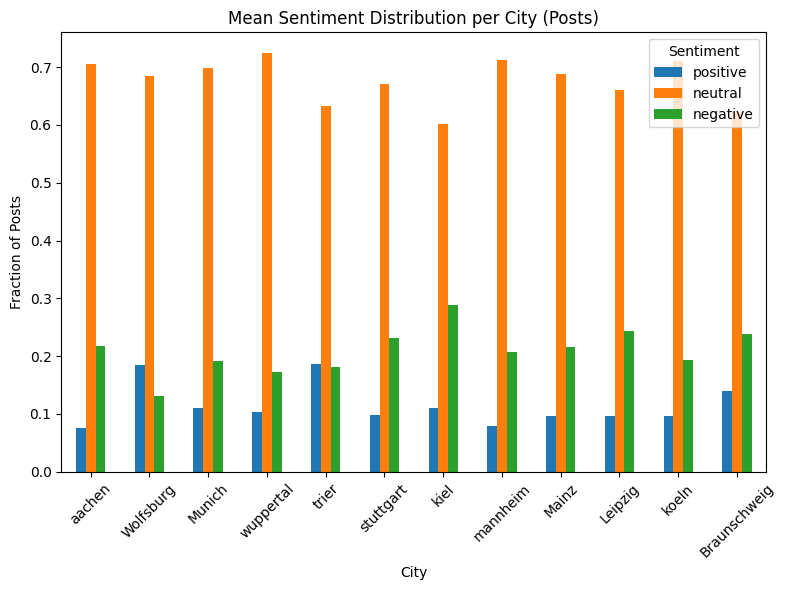

In [14]:
# Plot mean positivity, neutrality, and negativity per city
mean_sentiments = []
for city in metrics_results:
    post_counts = metrics_results[city]["post_counts"]
    total = sum(post_counts.values())
    mean_pos = post_counts.get("positive", 0) / total if total else 0
    mean_neu = post_counts.get("neutral", 0) / total if total else 0
    mean_neg = post_counts.get("negative", 0) / total if total else 0
    mean_sentiments.append({
        "city": city,
        "positive": mean_pos,
        "neutral": mean_neu,
        "negative": mean_neg
    })
mean_df = pd.DataFrame(mean_sentiments).set_index("city")
mean_df.plot(kind="bar", figsize=(8,6))
plt.title("Mean Sentiment Distribution per City (Posts)")
plt.ylabel("Fraction of Posts")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

## TODO

normalize over city reddits. 
take average c score over comment per city, 
violin graph for distribution